In [1]:
# 0) Environment setup (run on Colab)
# If you start a fresh Colab runtime you can uncomment below to install torch if necessary:
# !pip install torch torchvision --quiet

import torch, torchvision, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import datasets, transforms
import numpy as np, random, time, os
from copy import deepcopy
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision.models import resnet50, resnet18
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from functools import partial
from datasets import load_dataset

seed = 0\

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

# 0) Environment setup (run on Colab)
# If you start a fresh Colab runtime you can uncomment below to install torch if necessary:
# !pip install torch torchvision --quiet
# --- Standard Library ---
import os
import time
import math
import random
from copy import deepcopy
from functools import partial
from collections import OrderedDict
from pathlib import Path
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

# --- Third-Party Data & Plotting ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# --- PyTorch Core ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.cuda.amp import autocast, GradScaler

# --- PyTorch Data Utilities ---
from torch.utils.data import Dataset, DataLoader, Subset, random_split

# --- Torchvision ---
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.models import resnet18, resnet50

# Note: 'CIFAR10' is available via 'datasets.CIFAR10'
from torchvision.datasets import CIFAR10

seed = 0\

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda
Device: cuda


In [2]:
# 1) Utilities: flattening, cosine similarity, pairwise stats
def flat_params_from_model(model):
  return parameters_to_vector([p for p in model.parameters() if p.requires_grad]).detach().cpu()

def set_flat_params_to_model(model, flat_vec):
  if isinstance(flat_vec, (list, np.ndarray)):
    flat_vec = torch.from_numpy(np.array(flat_vec))
  vector_to_parameters(flat_vec.to(next(model.parameters()).device), [p for p in model.parameters() if p.requires_grad])

def cosine_sim_np(a, b):
  a = np.asarray(a, dtype=float).ravel()
  b = np.asarray(b, dtype=float).ravel()
  denom = (np.linalg.norm(a) * np.linalg.norm(b) + 1e-12)
  return float(np.dot(a, b) / denom)

def pairwise_cosine_stats(list_of_flat_grads):
  n = len(list_of_flat_grads)
  sims = []
  for i in range(n):
    for j in range(i+1, n):
      sims.append(cosine_sim_np(list_of_flat_grads[i], list_of_flat_grads[j]))
  if len(sims) == 0:
    return 0.0, 0.0
  return float(np.min(sims)), float(np.mean(sims))

In [3]:
# 2) Fed-GGA utilities (seed-based perturbations & client scoring)
def sample_k_seeds(K, base_seed=None):
  rng = np.random.RandomState(base_seed)
  return [int(rng.randint(0, 2**31 - 1)) for _ in range(K)]

def get_heldout_split(domain_loaders, held_out):
  assert held_out in domain_loaders, f"{held_out} is not a valid domain!"

  test_loader = domain_loaders[held_out]
  train_loaders = [dl for name, dl in domain_loaders.items() if name != held_out]

  return train_loaders, test_loader, held_out

In [4]:
from abc import ABC, abstractmethod
from typing import Dict, List
import torch

GradientDict = Dict[str, torch.Tensor]

class AggregationStrategy(ABC):
    """Abstract base class for gradient aggregation strategies."""
    
    @abstractmethod
    def aggregate(self, gradients: List[GradientDict]) -> Dict[str, torch.Tensor]:
        """Aggregate gradients from multiple clients."""
        pass


class AgreementWeightedFedAvg(AggregationStrategy):
    """
    Agreement-Weighted Federated Averaging.
    
    Computes per-parameter agreement weights based on sign consensus:
    W_j = |Σ sign((g_i)_j)| / N
    
    Final update: g_avg ⊙ W (element-wise multiplication)
    """
    
    def __init__(self, verbose: bool = False):
        self.verbose = verbose
        self.last_agreement_weights = {}
    
    def compute_average_gradient(
        self, 
        gradients: List[GradientDict]
    ) -> Dict[str, torch.Tensor]:
        """Compute g_avg = (1/N) * Σ g_i"""
        n = len(gradients)
        averaged = {}
        
        param_names = gradients[0].gradients.keys()
        
        for name in param_names:
            grad_sum = sum(g.gradients[name] for g in gradients)
            averaged[name] = grad_sum / n
        
        return averaged
    
    def compute_agreement_weights(
        self, 
        gradients: List[GradientDict]
    ) -> Dict[str, torch.Tensor]:
        """
        Compute per-parameter agreement weights:
        W_j = |Σ sign((g_i)_j)| / N
        """
        n = len(gradients)
        weights = {}
        
        param_names = gradients[0].gradients.keys()
        
        for name in param_names:
            # Sum of signs for each parameter across all clients
            sign_sum = sum(torch.sign(g.gradients[name]) for g in gradients)
            
            # Absolute value normalized by number of clients
            weights[name] = torch.abs(sign_sum) / n
        
        return weights
    
    def aggregate(self, gradients: List[GradientDict]) -> Dict[str, torch.Tensor]:
        """
        Aggregate gradients using agreement weighting.
        
        Returns: g_avg ⊙ W
        """
        if not gradients:
            raise ValueError("Cannot aggregate empty gradient list")
        
        # Step 1: Compute average gradient
        g_avg = self.compute_average_gradient(gradients)
        
        # Step 2: Compute agreement weights
        weights = self.compute_agreement_weights(gradients)
        self.last_agreement_weights = weights
        
        # Step 3: Apply element-wise multiplication
        weighted_gradient = {
            name: g_avg[name] * weights[name]
            for name in g_avg.keys()
        }
        
        if self.verbose:
            for name in weights.keys():
                w = weights[name]
                print(f"  {name}: Agreement - Min: {w.min():.3f}, "
                      f"Max: {w.max():.3f}, Mean: {w.mean():.3f}")
        
        return weighted_gradient
    
    def get_agreement_statistics(self) -> Dict[str, Dict[str, float]]:
        """Get statistics about the last computed agreement weights."""
        stats = {}
        for name, weight in self.last_agreement_weights.items():
            stats[name] = {
                "min": float(weight.min()),
                "max": float(weight.max()),
                "mean": float(weight.mean()),
                "std": float(weight.std())
            }
        return stats

In [5]:
class PruningFedAvg(AggregationStrategy):
    def __init__(self, threshold: float = 0.3, patience: int = 5):
        self.threshold = threshold
        self.patience = patience
        self.pruning_rate = 0.0
        # Memory to store how many consecutive rounds a parameter has been in conflict
        self.consecutive_conflict_counts = {} 
        self.last_agreement_weights = {}

    def compute_agreement_weights(self, gradients: List[GradientDict]):
        n_clients = len(gradients)

        weights = {}
        for gradient in gradients:
            for name, grad in gradient.gradients.items():
                if name not in weights:
                    weights[name] = torch.zeros_like(grad)
                weights[name] += torch.sign(grad)
        for name in weights:
            weights[name] = torch.abs(weights[name]) / n_clients
        return weights

    def aggregate(self, gradients: List[GradientDict]):
        N = len(gradients)
        param_names = gradients[0].gradients.keys()
        
        # 1. Calculate standard average gradient
        g_avg = {name: sum(g.gradients[name] for g in gradients) / N for name in param_names}
        

        weights = self.compute_agreement_weights(gradients)

        self.last_agreement_weights = weights
        
        for name in g_avg.keys():
            g_avg[name] = g_avg[name] * weights[name]

        pruned_grads = {}
        total_params, pruned_params = 0, 0
        
        for name in param_names:
            # 2. Calculate Agreement W_j
            sign_sum = sum(torch.sign(g.gradients[name]) for g in gradients)
            agreement = torch.abs(sign_sum) / N
            
            # Initialize counter for this parameter layer if it doesn't exist
            if name not in self.consecutive_conflict_counts:
                self.consecutive_conflict_counts[name] = torch.zeros_like(agreement)

            # 3. Check for conflict: If agreement < threshold, increment count. Else, RESET to 0.
            # (agreement < self.threshold) creates a boolean mask
            has_conflict = (agreement < self.threshold)
            
            # Increment where there is conflict
            self.consecutive_conflict_counts[name] += has_conflict.float()
            
            # IMPORTANT: Reset count to 0 for any parameter that NOW reaches consensus
            self.consecutive_conflict_counts[name] *= has_conflict.float()

            # 4. Generate the Pruning Mask
            # Mask is 0 only if the conflict count has reached the 'patience' limit (e.g., 5)
            mask = (self.consecutive_conflict_counts[name] < self.patience).float()
            
            # 5. Apply Pruning
            pruned_grads[name] = g_avg[name] * mask
            
            # Track statistics
            total_params += mask.numel()
            pruned_params += (mask == 0).sum().item()
            
        pruning_rate = (pruned_params / total_params) * 100
        self.pruning_rate = pruning_rate
        return pruned_grads, pruning_rate


    def get_agreement_statistics(self) -> Dict[str, Dict[str, float]]:
        """Get statistics about the last computed agreement weights."""
        stats = {}
        for name, weight in self.last_agreement_weights.items():
            stats[name] = {
                "min": float(weight.min()),
                "max": float(weight.max()),
                "mean": float(weight.mean()),
                "std": float(weight.std())
            }
        return stats

In [6]:
ds = load_dataset("flwrlabs/pacs")

train_transform = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])
test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

class HFPACSDomainDataset(Dataset):
  def __init__(self, hf_ds, domain_name, transform=None):
    self.transform = transform
    self.indices = [i for i, ex in enumerate(hf_ds) if ex["domain"] == domain_name]
    self.hf_ds = hf_ds

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    ex = self.hf_ds[self.indices[idx]]
    img = ex["image"]           
    label = int(ex["label"])    
    if self.transform is not None:
      img = self.transform(img)
    return img, label

# Inspect domains present in the HF dataset (sanity)
hf_root = ds  # dataset dict returned by load_dataset
# If dataset has a single split named "train", use that
split_name = list(hf_root.keys())[0]   # usually "train"
hf_split = hf_root[split_name]

# Collect unique domains (should be 4)
all_domains = sorted(list(set(hf_split["domain"])))
print("HF PACS domains found:", all_domains)

# Build domain-specific PyTorch DataLoaders (match your previous batch size / shuffle choices)
batch_size = 32
num_workers = 2

domain_loaders = {}
for dom in all_domains:
    # For 'sketch' use test transform (as you did) otherwise train_transform
    tf = test_transform if dom == "sketch" else train_transform
    ds_dom = HFPACSDomainDataset(hf_split, dom, transform=tf)
    # shuffle=True for training domains, keep sketch shuffle consistent with earlier (you used shuffle=True for sketch earlier too)
    shuffle_flag = True if dom != "cartoon" else False  # follow your original: cartoon had shuffle=False, adjust if needed
    loader = DataLoader(ds_dom, batch_size=batch_size, shuffle=shuffle_flag, num_workers=num_workers)
    domain_loaders[dom] = loader

# ensure ordering same as before and create train/test split using your helper
domain_names = list(domain_loaders.keys())
print("Built domain_loaders:", domain_names)

# Use your helper to get train_loaders and test_loader (held_out = "sketch" as before)
train_loaders, test_loader, held_out_name = get_heldout_split(domain_loaders, "sketch")

# quick sanity: print one batch shape from a domain
sample_domain = list(domain_loaders.keys())[0]
xb, yb = next(iter(domain_loaders[sample_domain]))
print(f"Sample batch from domain={sample_domain}: images {xb.shape}, labels {yb.shape}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

HF PACS domains found: ['art_painting', 'cartoon', 'photo', 'sketch']
Built domain_loaders: ['art_painting', 'cartoon', 'photo', 'sketch']
Sample batch from domain=art_painting: images torch.Size([32, 3, 224, 224]), labels torch.Size([32])


In [7]:
# Uniform delta sampler (paper's U(-rho, rho) per-parameter, scaled by model norm)
def make_uniform_delta_from_seed(seed, prototype_vector, rho, device='cpu', scale_by_norm=False):
    # use a local generator to avoid global torch RNG side-effects
    gen = torch.Generator(device=device)
    gen.manual_seed(int(seed) & 0xffffffff)
    flat = prototype_vector.to(device)
    uni = (torch.rand(flat.shape, generator=gen, device=device) * 2.0 - 1.0) * rho
    if scale_by_norm:
        model_norm = torch.norm(flat) + 1e-12
        delta = uni * model_norm
    else:
        delta = uni
    return delta

def client_compute_scores_for_fedgga(model, loss_fn, data_loader, seeds, rho, device='cpu', 
                                     scale_by_norm=False, search_head_only=True):
    """
    Compute reference gradient on one small batch, then for each seed:
      - apply delta IN-PLACE to model parameters (fast)
      - forward/backward to get g_k (torch tensor on device)
      - compute cosine similarity on device between g_k and ref_grad
      - revert the delta IN-PLACE
    Returns:
      scores (list of float) length == len(seeds),
      ref_grad_numpy (np.array),
      loss_ref (float),
      losses_k (list of float) length == len(seeds)
    """
    local_model = deepcopy(model).to(device)
    local_model.train()

    # Get one small batch for scoring and move to device
    it = iter(data_loader)
    xs, ys = next(it)
    xs, ys = xs.to(device), ys.to(device)

    # Optionally micro-batch if you want cheaper scoring
    # micro_b = min(8, xs.shape[0])
    # xs, ys = xs[:micro_b], ys[:micro_b]

    # Select parameters that will be perturbed / measured
    # param_list = [p for p in local_model.parameters() if p.requires_grad]
    if search_head_only:
        param_list, param_names = get_head_param_list_and_names(local_model)
    else:
        param_list = [p for p in local_model.parameters() if p.requires_grad]
    if len(param_list) == 0:
        return [0.0] * len(seeds), np.zeros(1), 0.0, [0.0] * len(seeds)
        
    numels = [p.numel() for p in param_list]
    flat_theta = parameters_to_vector(param_list).detach().to(device)

    local_model.zero_grad()
    out = local_model(xs)
    loss_ref_tensor = loss_fn(out, ys)
    loss_ref = float(loss_ref_tensor.detach().cpu().item())
    loss_ref_tensor.backward()

    ref_grad_parts = []
    for p in param_list:
        g = p.grad
        if g is None:
            ref_grad_parts.append(torch.zeros(p.numel(), device=device))
        else:
            ref_grad_parts.append(g.detach().view(-1))
    ref_grad_t = torch.cat(ref_grad_parts)            # on device
    ref_grad_numpy = ref_grad_t.detach().cpu().numpy()

    scores = []
    losses_k = []

    # Helper: apply delta in-place and revert
    def apply_delta_inplace(delta_flat):
        offset = 0
        for p, n in zip(param_list, numels):
            seg = delta_flat[offset: offset + n].view_as(p.data)
            p.data.add_(seg)
            offset += n

    def revert_delta_inplace(delta_flat):
        offset = 0
        for p, n in zip(param_list, numels):
            seg = delta_flat[offset: offset + n].view_as(p.data)
            p.data.sub_(seg)
            offset += n

    # Loop over all candidate seeds -> produce one score per seed
    for seed in seeds:
        delta = make_uniform_delta_from_seed(seed, flat_theta, rho, device=device, scale_by_norm=scale_by_norm)
        apply_delta_inplace(delta)

        local_model.zero_grad()
        out_k = local_model(xs)
        loss_k_tensor = loss_fn(out_k, ys)
        loss_k = float(loss_k_tensor.detach().cpu().item())
        loss_k_tensor.backward()

        # collect gk as a single torch tensor (on device)
        gk_parts = []
        for p in param_list:
            g = p.grad
            if g is None:
                gk_parts.append(torch.zeros(p.numel(), device=device))
            else:
                gk_parts.append(g.detach().view(-1))
        gk_t = torch.cat(gk_parts)

        # cosine sim on device (use small eps)
        denom = (torch.norm(gk_t) * torch.norm(ref_grad_t) + 1e-12)
        sim_t = float(torch.dot(gk_t, ref_grad_t).item() / denom.item())

        scores.append(sim_t)
        losses_k.append(loss_k)

        # revert delta in-place
        revert_delta_inplace(delta)

    # Safety: ensure local_model params exactly restored (optional)
    set_flat_params_to_model(local_model, flat_theta)

    return scores, ref_grad_numpy, loss_ref, losses_k

def fedavg_from_state_dicts(state_dicts):
    """
    Given a list of PyTorch state_dict() objects (assumed identical keys),
    return a new state_dict that is the simple average of the tensors.
    """
    if len(state_dicts) == 0:
        raise ValueError("No state dicts provided to fedavg_from_state_dicts")
    n = len(state_dicts)
    keys = list(state_dicts[0].keys())
    new_sd = {}
    for k in keys:
        # sum up as float32 to avoid dtype issues
        accum = None
        for sd in state_dicts:
            v = sd[k].cpu().float()
            if accum is None:
                accum = v.clone()
            else:
                accum += v
        new_sd[k] = (accum / float(n))
    return new_sd


In [8]:
from torch import mode


class FedClient:
    def __init__(self, name, train_loader, test_loader, device):
        self.name = name
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def score_seeds(self, model, loss_fn, seeds, rho, scale_by_norm, search_head_only):
        return client_compute_scores_for_fedgga(model, loss_fn, self.train_loader, seeds, rho, device=self.device, 
                                                scale_by_norm=scale_by_norm, search_head_only=search_head_only)

    def local_update(self, global_model, local_epochs=1, lr=0.01, max_steps=None, use_amp=False):
        model = deepcopy(global_model).to(self.device)
        # opt = torch.optim.Adam(model.parameters(), lr=lr)
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        if len(trainable_params) == 0:
            return deepcopy(model.state_dict())
            
        opt = torch.optim.Adam(trainable_params, lr=lr)
            
        loss_fn = nn.CrossEntropyLoss()
        model.train()

        scaler = GradScaler() if (use_amp and self.device.startswith('cuda')) else None

        step = 0
        for _ in range(local_epochs):
            for xb, yb in self.train_loader:
                xb, yb = xb.to( self.device), yb.to( self.device)
                opt.zero_grad()
                if scaler is not None:
                    with autocast():
                        logits = model(xb)
                        loss = loss_fn(logits, yb)
                    scaler.scale(loss).backward()
                    scaler.step(opt)
                    scaler.update()
                else:
                    logits = model(xb)
                    loss = loss_fn(logits, yb)
                    loss.backward()
                    opt.step()
                step += 1
                if (max_steps is not None) and (step >= max_steps):
                    break
            if (max_steps is not None) and (step >= max_steps):
                break

        return deepcopy(model.state_dict())
    
    def compute_avg_gradient(self, global_model, local_epochs=1, max_batches=None, device=None):
        """
        Compute average gradients over local data WITHOUT applying optimizer steps.
        Use a deepcopy of `global_model` (server model) so we don't require client-local model attr.
        Returns: dict mapping parameter name -> gradient tensor (on CPU).
        """
        device = device or self.device
        # local copy of server/global model to avoid modifying server state
        model = deepcopy(global_model).to(device)
        model.train()

        loss_fn = nn.CrossEntropyLoss()

        accumulated = None
        batch_count = 0
        step = 0

        for ep in range(local_epochs):
            for xb, yb in self.train_loader:
                if (max_batches is not None) and (step >= max_batches):
                    break
                xb, yb = xb.to(device), yb.to(device)
                model.zero_grad()
                out = model(xb)
                loss = loss_fn(out, yb)
                loss.backward()

                # collect this batch grads (move to CPU to keep memory predictable)
                batch_grads = {}
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        batch_grads[name] = param.grad.detach().cpu().clone()

                if accumulated is None:
                    accumulated = {k: v.clone() for k, v in batch_grads.items()}
                else:
                    for k, v in batch_grads.items():
                        if k in accumulated:
                            accumulated[k] += v
                        else:
                            accumulated[k] = v.clone()

                batch_count += 1
                step += 1
            if (max_batches is not None) and (step >= max_batches):
                break

        if accumulated is None:
            return {}

        for k in accumulated:
            accumulated[k] = accumulated[k] / float(batch_count)

        return accumulated  


    def eval_on_test(self, model):
        model = deepcopy(model).to(self.device)
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x,y in self.test_loader:
                x,y = x.to(self.device), y.to(self.device)
                preds = model(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        return correct / total if total > 0 else 0.0

class FedGGAServer:
    def __init__(self, server_model, clients, device, config, test_loader):
        self.model = deepcopy(server_model).to(device)
        self.clients = clients
        self.device = device
        self.config = config.copy()
        self.log = []
        self.W_history = []
        self.test_loader = test_loader

    def run(self):
        cfg = self.config
        loss_fn = nn.CrossEntropyLoss()
        extra_grad_evals = 0
        for rnd in range(cfg['rounds']):
            t0 = time.time()
            if cfg['R_start'] <= rnd <= cfg['R_end'] and cfg['enable_gga']:
                seeds = sample_k_seeds(cfg['K'], base_seed=cfg.get('base_seed', 1234) + rnd)
                client_scores = []   # shape (n_clients, K)
                client_ref_grads = []
                client_ref_losses = []
                client_losses_k = [] # list of lists: for each client, list of K losses

                # print("clients starting")
                # Each client computes scores and returns ref_grad & losses
                for c in self.clients:
                    scores, ref_grad, ref_loss, losses_k = c.score_seeds(self.model, loss_fn, seeds, cfg['rho'], 
                                                             scale_by_norm=cfg.get('scale_by_norm', False),
                                                             search_head_only=cfg.get('search_last_layer_only', True))
                    client_scores.append(scores)
                    client_ref_grads.append(ref_grad)
                    client_ref_losses.append(ref_loss)
                    client_losses_k.append(losses_k)
                    extra_grad_evals += (1 + len(seeds)) * 1  # approx: 1 ref + K candidates per client

                # compute reference sim LB: min pairwise among client_ref_grads
                sim_ref_min, sim_ref_mean = pairwise_cosine_stats(client_ref_grads)
                LB = float(np.mean(client_ref_losses))  # average ref loss across clients

                # aggregate candidate scores/losses across clients
                arr_scores = np.stack(client_scores, axis=0)  # (n_clients, K)
                avg_scores = np.mean(arr_scores, axis=0)     # average of per-client sim proxies
                arr_losses_k = np.stack(client_losses_k, axis=0)  # (n_clients, K)
                avg_losses_k = np.mean(arr_losses_k, axis=0)

                # apply acceptance rule per candidate: avg_scores[k] > sim_ref_min AND avg_losses_k[k] - LB < loss_relax
                loss_relax = cfg.get('loss_relax', 0.1)
                accepted_indices = []
                for k_idx in range(len(seeds)):
                    if (avg_scores[k_idx] > sim_ref_min) and ((avg_losses_k[k_idx] - LB) < loss_relax):
                        accepted_indices.append(k_idx)

                # choose best among accepted by highest avg_score (if none accepted, choose best avg_score but only if not too much loss)
                if len(accepted_indices) > 0:
                    best_k = int(np.argmax(avg_scores[accepted_indices]))
                    best_k = accepted_indices[best_k]
                else:
                    # fallback: choose argmax avg_scores but require loss condition (if not satisfied, skip applying any delta)
                    best_k = int(np.argmax(avg_scores))
                    if not ((avg_losses_k[best_k] - LB) < loss_relax):
                        best_k = None

                # apply delta if best_k exists
                if best_k is not None:
                    best_seed = seeds[best_k]
                    if cfg.get('search_last_layer_only', True):
                        server_param_list, server_param_names = get_head_param_list_and_names(self.model)
                    else:
                        server_param_list = [p for p in self.model.parameters() if p.requires_grad]
                    
                    flat_theta = parameters_to_vector(server_param_list).detach().to(self.device)
                    delta = make_uniform_delta_from_seed(best_seed, flat_theta.cpu(), cfg['rho'], device=self.device,
                                                        scale_by_norm=cfg.get('scale_by_norm'))
                    beta = cfg.get('beta', 1.0)
                    new_flat = (flat_theta.to(self.device) + beta * delta.to(self.device)).clone()
                    
                    offset = 0
                    for p, n in zip(server_param_list, [p.numel() for p in server_param_list]):
                        seg = new_flat[offset: offset + n].view_as(p.data)
                        p.data.copy_(seg)
                        offset += n
                    # set_flat_params_to_model(self.model, new_flat)
                    applied = True
                else:
                    applied = False

                # diagnostics
                min_sim = sim_ref_min
                mean_sim = sim_ref_mean

            else:
                min_sim, mean_sim, applied = None, None, False

            client_state_dicts = []
            client_flat_updates = []

            if cfg['enable_dampening'] and (rnd >= cfg.get("D_start") and rnd < cfg.get("P_start")):
                aggregation = AgreementWeightedFedAvg(verbose=cfg.get('agg_verbose', False))
            
                # Use server model param order (only trainable params) to ensure consistent flattening
                server_param_names = [name for name, p in self.model.named_parameters() if p.requires_grad]
                param_numels = {name: int(p.numel()) for name, p in self.model.named_parameters() if p.requires_grad}
            
                # 1) compute avg gradients per client (CPU tensors) using the current server model snapshot
                gradient_dicts = []
                for c in self.clients:
                    grads_cpu = c.compute_avg_gradient(
                        global_model=self.model,
                        local_epochs=cfg['local_epochs'],
                        max_batches=cfg['max_client_steps'],
                        device=self.device
                    )
                    if not grads_cpu:
                        # client didn't return gradients (e.g. empty loader) -> skip
                        continue
            
                    # normalize/ensure grads_cpu has CPU torch.Tensor values for server_param_names
                    # fill missing params with zeros of correct size
                    grads_fixed = {}
                    for name in server_param_names:
                        if name in grads_cpu:
                            # ensure it's a torch.Tensor on CPU
                            t = grads_cpu[name]
                            if isinstance(t, np.ndarray):
                                t = torch.from_numpy(t)
                            grads_fixed[name] = t.detach().cpu().clone()
                        else:
                            grads_fixed[name] = torch.zeros(param_numels[name], dtype=torch.float32)
            
                    # minimal wrapper object expected by AgreementWeightedFedAvg (has .gradients and .client_id)
                    class _G:
                        def __init__(self, d, cid):
                            self.gradients = d
                            self.client_id = cid
                    gradient_dicts.append(_G(grads_fixed, c.name))
            
                # If no gradients, fallback to normal FedAvg local updates (keeps loop central)
                if len(gradient_dicts) == 0:
                    client_state_dicts = []
                    for c in self.clients:
                        sd = c.local_update(self.model, local_epochs=cfg['local_epochs'],
                                            lr=cfg['local_lr'], max_steps=cfg['max_client_steps'], use_amp=cfg['use_amp'])
                        client_state_dicts.append(sd)
                    new_sd = fedavg_from_state_dicts(client_state_dicts)
                    self.model.load_state_dict(new_sd)
            
                    pct_pruned = 0.0
                    damp_W_mean = None
                    min_sim, mean_sim = None, None
                else:
                    # 2) compute flattened numpy vectors (CPU) for pairwise similarity stats
                    flat_list = []
                    for g in gradient_dicts:
                        parts = []
                        for name in server_param_names:
                            t = g.gradients.get(name)
                            if t is None:
                                parts.append(np.zeros(param_numels[name], dtype=np.float32))
                            else:
                                parts.append(t.reshape(-1).numpy())
                        flat_vec = np.concatenate(parts).astype(np.float32)
                        flat_list.append(flat_vec)
            
                    # compute pairwise stats (min and mean) using your pairwise_cosine_stats utility
                    min_sim, mean_sim = pairwise_cosine_stats(flat_list)  # expects list of 1D numpy arrays
            
                    # 3) aggregate with AgreementWeightedFedAvg (works on CPU tensors)
                    weighted_grad = aggregation.aggregate(gradient_dicts)   # dict: param_name -> CPU tensor
            
                    # 4) apply aggregated gradient to server model using server_lr_damp (single server update)
                    server_lr_damp = cfg.get('server_lr') 
                    with torch.no_grad():
                        for name, param in self.model.named_parameters():
                            if name in weighted_grad:
                                g_cpu = weighted_grad[name]  # CPU tensor
                                # if g_cpu is numpy, convert
                                if isinstance(g_cpu, np.ndarray):
                                    g_cpu = torch.from_numpy(g_cpu)
                                param.data.add_(-server_lr_damp * g_cpu.to(param.device))
            
                    # diagnostics: agreement stats (optional)
                    try:
                        damp_W_mean = float(np.mean([float(v.mean()) for v in aggregation.last_agreement_weights.values()])) \
                                     if hasattr(aggregation, 'last_agreement_weights') and aggregation.last_agreement_weights else None
                    except Exception:
                        damp_W_mean = None
            
                    pct_pruned = 0.0
            
            if cfg['enable_pruning'] and (rnd >= cfg.get("P_start") and rnd <= cfg.get("rounds")):
                aggregation = PruningFedAvg(threshold=cfg.get('P_tolerance'), patience=cfg.get('P_patience'))
            
                # 1) collect avg gradients (CPU tensors) from each client using same centralized loop
                gradient_dicts = []
                param_order = None
                for c in self.clients:
                    grads_cpu = c.compute_avg_gradient(
                        global_model=self.model,
                        local_epochs=cfg.get('local_epochs', 1),
                        max_batches=cfg.get('max_client_steps', None),
                        device=self.device
                    )
                    if not grads_cpu:
                        continue
                    if param_order is None:
                        param_order = list(grads_cpu.keys())
                    class _G:
                        def __init__(self, d, cid):
                            self.gradients = d
                            self.client_id = cid
                    gradient_dicts.append(_G(grads_cpu, c.name))
            
                # If no gradients were collected, fallback to normal FedAvg round so loop remains centralized
                if len(gradient_dicts) == 0:
                    client_state_dicts = []
                    for c in self.clients:
                        sd = c.local_update(self.model, local_epochs=cfg['local_epochs'],
                                            lr=cfg['local_lr'], max_steps=cfg['max_client_steps'], use_amp=cfg['use_amp'])
                        client_state_dicts.append(sd)
                    new_sd = fedavg_from_state_dicts(client_state_dicts)
                    self.model.load_state_dict(new_sd)
                    pct_pruned = 0.0
                    damp_W_mean = None
                    min_sim, mean_sim = None, None
                else:
                    # 2) Flatten per-client average gradients (numpy) to compute pairwise similarity diagnostics
                    flat_list = []
                    for g in gradient_dicts:
                        parts = []
                        for name in param_order:
                            arr = g.gradients.get(name)
                            if arr is None:
                                parts.append(np.zeros(0, dtype=float))   # unlikely, fallback
                            else:
                                parts.append(arr.reshape(-1).numpy())
                        flat_list.append(np.concatenate(parts))
                    # compute pairwise stats (returns min_sim, mean_sim over clients)
                    min_sim, mean_sim = pairwise_cosine_stats(flat_list)
            
                    # 3) Aggregate with PruningFedAvg -> it returns (pruned_grads, pruning_rate)
                    pruned_grads, pruning_rate = aggregation.aggregate(gradient_dicts)
            
                    # 4) Apply pruned gradients to server model in-place using server_lr_prune
                    server_lr_prune = cfg.get('server_lr', 1e-3) 
                    with torch.no_grad():
                        for name, param in self.model.named_parameters():
                            if name in pruned_grads:
                                g_cpu = pruned_grads[name]   # CPU tensor
                                param.data.add_(-server_lr_prune * g_cpu.to(self.device))
            
                    # diagnostics
                    pct_pruned = pruning_rate
                    try:
                        agree_stats = aggregation.get_agreement_statistics()
                        damp_W_mean = np.mean([s['mean'] for s in agree_stats.values()]) if len(agree_stats) > 0 else None
                    except Exception:
                        damp_W_mean = None
            
            else:
                for c in self.clients:
                    # print('local update client: ', c.name)
                    sd = c.local_update(self.model, local_epochs=cfg['local_epochs'], lr=cfg['local_lr'], max_steps=cfg['max_client_steps'], use_amp=cfg['use_amp'])
                    client_state_dicts.append(sd)
                    # compute flat update for dampening/pruning
                    client_model = deepcopy(self.model)
                    client_model.load_state_dict(sd)
                    flat_client = parameters_to_vector([p for p in client_model.parameters() if p.requires_grad]).detach().cpu().numpy()
                    flat_server = parameters_to_vector([p for p in self.model.parameters() if p.requires_grad]).detach().cpu().numpy()
                    client_flat_updates.append(flat_client - flat_server)
                
                new_sd = fedavg_from_state_dicts(client_state_dicts)
                # convert types back to server model's dtype/device if necessary
                # load into server model
                self.model.load_state_dict(new_sd)
                
                pct_pruned = 0.0
                damp_W_mean = None

            # # optionally apply GGA-L instead of full search in non-anneal rounds (cheap)
            # if cfg.get('use_gga_l', False) and not (cfg['R_start'] <= rnd <= cfg['R_end'] and cfg['enable_gga']):
            #     # estimate mean_sim (use last collected client_ref_grads if exist)
            #     if 'client_ref_grads' in locals() and len(client_ref_grads)>0:
            #         _, mean_sim_est = pairwise_cosine_stats(client_ref_grads)
            #     else:
            #         mean_sim_est = 0.0
            #     alpha = compute_alpha_from_pairwise_mean(mean_sim_est, gamma=cfg.get('gga_l_gamma', 1e-3))
            #     noise = gga_l_noise_vector(self.model, device=self.device)
            #     flat = parameters_to_vector([p for p in self.model.parameters() if p.requires_grad]).detach()
            #     new_flat = (flat + alpha * noise).clone()
            #     set_flat_params_to_model(self.model, new_flat)

            # evaluate (clients' local test loaders might be used; for held-out evaluation evaluate separately)
            accs = [c.eval_on_test(self.model) for c in self.clients]
            avg_acc = float(np.mean(accs))

            # logging
            self.log.append({
                'round': rnd,
                'avg_client_acc': avg_acc,
                'min_pairwise_sim': min_sim,
                'mean_pairwise_sim': mean_sim,
                'applied_delta': bool(applied),
                'applied_delta': applied,
                'pct_pruned': pct_pruned,
                'damp_W_mean': damp_W_mean,
                'time': time.time() - t0,
                'extra_grad_evals_est': extra_grad_evals
            })

            if rnd%5==0:
              print(f"[R{rnd}] avg_acc={avg_acc:.4f} min_sim={min_sim} mean_sim={mean_sim} applied_delta={applied}")
              # print(f"[R{rnd}] avg_acc={avg_acc:.4f} min_sim={min_sim} mean_sim={mean_sim} applied_delta={applied} pct_pruned={pct_pruned:.3f}")

        return self.log

# ==== END of Fed-GGA implementation ====


In [9]:
import torch.nn.functional as F

class SmallCNN(nn.Module):
  def __init__(self, num_classes=7):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)   
      self.bn1   = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
      self.bn2   = nn.BatchNorm2d(64)
      self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
      self.bn3   = nn.BatchNorm2d(128)
      self.pool  = nn.MaxPool2d(2)  
      self.avgpool = nn.AdaptiveAvgPool2d((1,1)) 
      self.fc = nn.Linear(128, num_classes)

  def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = self.pool(x)                    
      x = F.relu(self.bn2(self.conv2(x)))
      x = self.pool(x)                    
      x = F.relu(self.bn3(self.conv3(x)))
      x = self.pool(x)                    
      x = self.avgpool(x)                 
      x = x.view(x.size(0), -1)           
      x = self.fc(x)                      
      return x

In [10]:
import time
import pandas as pd
from copy import deepcopy

def eval_global_on_test(model, test_loader, device):
    model = deepcopy(model).to(device)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total if total > 0 else 0.0

def set_global_seed(seed):
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def run_heldout_experiments(domain_loaders,
                            seeds=[0],
                            optimizer='adam',
                            save_dir='/kaggle/working/fed_gga_results'):
    os.makedirs(save_dir, exist_ok=True)
    domains = list(domain_loaders.keys())
    num_classes = 7

    results = []
    for held_out in domains:
        train_domains = [d for d in domains if d != held_out]
        print(f"\n=== Held-out: {held_out}  (train: {train_domains}) ===")

        for seed in seeds:
            set_global_seed(seed)
            print(f" - seed {seed}")
            # build clients
            clients = []
            for d in train_domains:
                clients.append(FedClient(d, domain_loaders[d], domain_loaders[d], device))

            # model = make_model(name=model_name, num_classes=num_classes).to(device)
            model=SmallCNN(num_classes=7).to(device)
            
            cfg = {}
            cfg.setdefault('rounds', 50)
            cfg.setdefault('R_start', 2)
            cfg.setdefault('R_end', 15)
            cfg.setdefault('D_start', 20)
            cfg.setdefault('P_start', 42)
            cfg.setdefault('P_tolerance', 0.2)
            cfg.setdefault('P_patience', 1)
            cfg.setdefault('K', 8)
            cfg.setdefault('rho', 1e-5)
            cfg.setdefault('beta', 0.3)
            cfg.setdefault('local_epochs', 2)
            cfg.setdefault('max_client_steps', 100)
            cfg.setdefault('local_lr',  1e-3)
            cfg.setdefault('server_lr', 1e-3)
            cfg.setdefault('enable_gga', True)
            cfg.setdefault('enable_dampening', True)
            cfg.setdefault('enable_pruning', True)
            cfg.setdefault('use_amp', True)
            cfg.setdefault('scale_by_norm', True)
            cfg.setdefault('search_last_layer_only', False)
            cfg.setdefault('loss_relax', 0.05)

            held_test_loader = domain_loaders[held_out]
            server = FedGGAServer(model, clients, device, cfg, test_loader=held_test_loader)

            t0 = time.time()
            run_log = server.run()
            run_time = time.time() - t0

            # held-out evaluation
            held_client = FedClient(held_out, None, held_test_loader, device)
            held_out_acc = held_client.eval_on_test(server.model)

            run_id = f"{held_out}_seed{seed}"
            pd.DataFrame(run_log).to_csv(os.path.join(save_dir, f"runlog_{run_id}.csv"), index=False)
            
            model_path = os.path.join(save_dir, f"final_model_{run_id}.pt")
            torch.save(server.model.state_dict(), model_path)
            print("Saved model:", model_path)

            results.append({
                'dataset': 'PACS',
                'held_out': held_out,
                'seed': seed,
                'optimizer': optimizer,
                'held_out_acc': held_out_acc,
                'time_s': run_time,
                'cfg_K': cfg['K'],
                'cfg_rho': cfg['rho'],
                'cfg_R_start': cfg['R_start'],
                'cfg_R_end': cfg['R_end'],
            })

            print(f" -> held_out {held_out} seed {seed} acc={held_out_acc:.4f} time={run_time:.1f}s")

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(save_dir, "per_run_results.csv"), index=False)
    
    domain_means = df.groupby('held_out')['held_out_acc'].mean()
    avg_across_domains = domain_means.mean()
    
    print("\nAverage accuracy across held-out domains:", avg_across_domains)

    summary = df.groupby('held_out')['held_out_acc'].agg(['mean','std']).reset_index()
    dataset_avg = summary['mean'].mean()
    summary.to_csv(os.path.join(save_dir, "per_domain_summary.csv"), index=False)

    # table-like CSV
    pacs_order = domains
    table_row = {}
    for d in pacs_order:
        r = summary[summary['held_out'] == d]
        if len(r) > 0:
            table_row[d] = f"{float(r['mean']):.3f} ± {float(r['std']):.3f}"
        else:
            table_row[d] = "N/A"
    table_row['Avg'] = f"{float(dataset_avg):.3f}"
    pd.DataFrame([table_row]).to_csv(os.path.join(save_dir, "pacs_table_row.csv"), index=False)

    print("\nSaved results to:", save_dir)
    return df, summary, table_row, server.model

# df_full, summary_full, table_full = run_heldout_experiments(domain_loaders, model_name='resnet50', cfg_base=cfg_full, seeds=[0,1,2], optimizer='adam', save_dir='/kaggle/working/fed_gga_full')
df_full, summary_full, table_full, trained_model = run_heldout_experiments(domain_loaders, seeds=[0], optimizer='adam', save_dir='/kaggle/working/fed_gga_full')


=== Held-out: art_painting  (train: ['cartoon', 'photo', 'sketch']) ===
 - seed 0


/tmp/ipykernel_24/887805067.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if (use_amp and self.device.startswith('cuda')) else None
/tmp/ipykernel_24/887805067.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[R0] avg_acc=0.1161 min_sim=None mean_sim=None applied_delta=False
[R5] avg_acc=0.1708 min_sim=-0.5401227555127828 mean_sim=-0.21854780280502897 applied_delta=True
[R10] avg_acc=0.1577 min_sim=-0.4035061536217562 mean_sim=-0.14166754539506068 applied_delta=True
[R15] avg_acc=0.2703 min_sim=-0.24963612903130536 mean_sim=-0.08382816015524364 applied_delta=True
[R20] avg_acc=0.2905 min_sim=-0.31645889774018593 mean_sim=-0.061105092788066716 applied_delta=False
[R25] avg_acc=0.2573 min_sim=0.17201866520525622 mean_sim=0.2542439433411969 applied_delta=False
[R30] avg_acc=0.2041 min_sim=-0.021244989134739573 mean_sim=0.0417372753053128 applied_delta=False
[R35] avg_acc=0.2929 min_sim=0.25856767549120346 mean_sim=0.34705582299458365 applied_delta=False
[R40] avg_acc=0.3242 min_sim=0.16765391130762072 mean_sim=0.19304065586933686 applied_delta=False
[R45] avg_acc=0.2305 min_sim=0.1948631923566992 mean_sim=0.2675955667875534 applied_delta=False
Saved model: /kaggle/working/fed_gga_full/final_mo

/tmp/ipykernel_24/16260683.py:123: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  table_row[d] = f"{float(r['mean']):.3f} ± {float(r['std']):.3f}"


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_runlog_file(path):
    """Load CSV runlog safely and normalize round column."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Runlog not found: {path}")
    df = pd.read_csv(path)
    if 'round' in df.columns:
        df['round'] = df['round'].astype(int)
        df = df.sort_values('round').reset_index(drop=True)
    return df

def _maybe_smooth(series, window):
    if window is None or window <= 1:
        return series
    return series.rolling(window=window, min_periods=1, center=False).mean()

def plot_all_heldout_global_curves(runlog_paths, labels=None, save_path=None, smooth_window=None, figsize=(9,5)):
    """
    Plot per-held-out global_accu curves.
      runlog_paths: list of file paths
      labels: optional list of labels for legend
      smooth_window: int or None (rolling smoothing)
    """
    plt.figure(figsize=figsize)
    any_plotted = False
    for i, p in enumerate(runlog_paths):
        if not os.path.exists(p):
            print(f"warning: runlog missing {p}; skipping")
            continue
        df = load_runlog_file(p)
        if 'avg_client_acc' not in df.columns:
            print(f"warning: 'avg_client_acc' not found in {p}; skipping")
            continue
        lab = (labels[i] if labels is not None and i < len(labels) else os.path.basename(p))
        y = pd.to_numeric(df['avg_client_acc'], errors='coerce')
        y = y.fillna(method='ffill').fillna(method='bfill')  # try to fill edges
        # y = _maybe_smooth(y, smooth_window)
        plt.plot(df['round'], y, marker='o', label=lab)
        any_plotted = True

    if not any_plotted:
        print("No avg_client_acc curves plotted (no files/columns found).")
        return

    plt.xlabel('round')
    plt.ylabel('held-out / global accuracy')
    plt.title('Held-out accuracy per round')
    plt.legend()
    plt.grid(True)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print("Saved", save_path)
    plt.show()


def plot_similarity_across_domains(runlog_paths_dict, save_path=None, smooth_window=None, figsize=(9,5)):
    """
    Plot mean_pairwise_sim across multiple domains.
      runlog_paths_dict: dict domain -> path
    """
    plt.figure(figsize=figsize)
    any_plotted = False
    for domain, path in runlog_paths_dict.items():
        if not os.path.exists(path):
            print(f"warning: runlog missing {path}; skipping {domain}")
            continue
        df = load_runlog_file(path)
        if 'mean_pairwise_sim' not in df.columns:
            print(f"warning: 'mean_pairwise_sim' not found in {path}; skipping {domain}")
            continue
        series = pd.to_numeric(df['mean_pairwise_sim'], errors='coerce')
        # fill NaNs sensibly: forward then backward
        series = series.fillna(method='ffill').fillna(method='bfill')
        # series = _maybe_smooth(series, smooth_window)
        plt.plot(df['round'], series, marker='o', label=domain)
        any_plotted = True

    if not any_plotted:
        print("No similarity curves plotted (no files/columns found).")
        return

    plt.xlabel('Round')
    plt.ylabel('Mean pairwise similarity')
    plt.title('Mean pairwise similarity (ref grads) per round')
    plt.legend()
    plt.grid(True)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print("Saved", save_path)
    plt.show()


def plot_global_and_similarity(runlog_paths_dict, save_path=None, smooth_window=None, figsize=(12,5)):
    """
    Two-panel plot: left = avg_client_acc per-domain, right = mean_pairwise_sim per-domain.
    runlog_paths_dict: dict label -> path
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    any_left = any_right = False

    for label, path in runlog_paths_dict.items():
        if not os.path.exists(path):
            print(f"warning: {path} missing; skipping {label}")
            continue
        df = load_runlog_file(path)
        rounds = df['round'] if 'round' in df.columns else np.arange(len(df))
        if 'avg_client_acc' in df.columns:
            ga = pd.to_numeric(df['avg_client_acc'], errors='coerce').fillna(method='ffill').fillna(method='bfill')
            # ga = _maybe_smooth(ga, smooth_window)
            ax1.plot(rounds, ga, marker='o', label=label)
            any_left = True
        if 'mean_pairwise_sim' in df.columns:
            ms = pd.to_numeric(df['mean_pairwise_sim'], errors='coerce').fillna(method='ffill').fillna(method='bfill')
            # ms = _maybe_smooth(ms, smooth_window)
            ax2.plot(rounds, ms, marker='o', label=label)
            any_right = True

    if any_left:
        ax1.set_xlabel('round'); ax1.set_ylabel('avg_client_acc'); ax1.set_title('Held-out/global accuracy')
        ax1.grid(True); ax1.legend()
    else:
        ax1.text(0.5, 0.5, 'No avg_client_acc data', ha='center', va='center'); ax1.axis('off')

    if any_right:
        ax2.set_xlabel('round'); ax2.set_ylabel('mean_pairwise_sim'); ax2.set_title('Mean pairwise similarity')
        ax2.grid(True); ax2.legend()
    else:
        ax2.text(0.5, 0.5, 'No similarity data', ha='center', va='center'); ax2.axis('off')

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print("Saved", save_path)
    plt.show()


No avg_client_acc curves plotted (no files/columns found).
No similarity curves plotted (no files/columns found).
Saved /kaggle/working/fed_gga_results/global_and_similarity.png


<Figure size 900x500 with 0 Axes>

<Figure size 900x500 with 0 Axes>

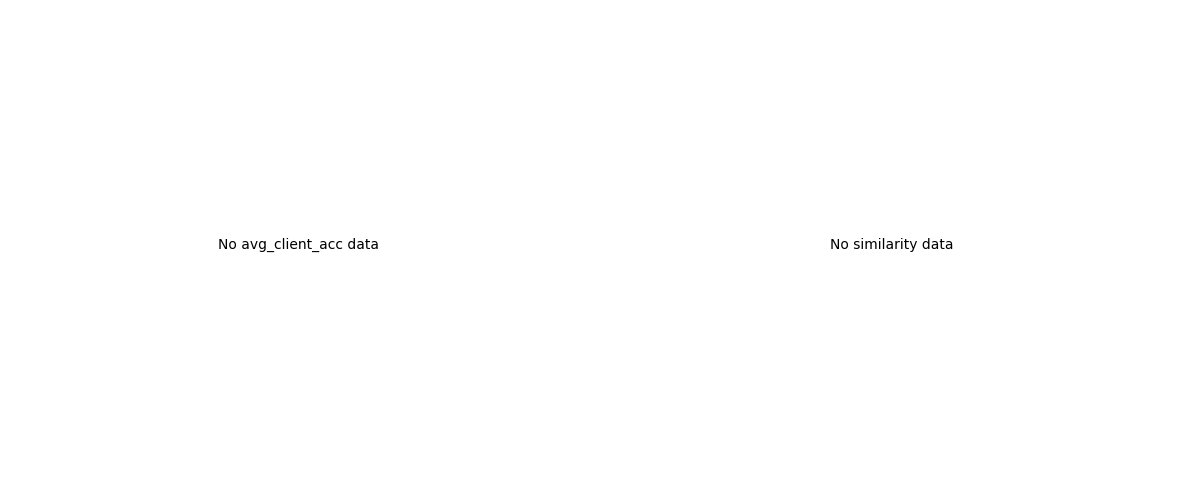

In [12]:
base = '/kaggle/working/fed_gga_results'  # update if needed
held_outs = ['photo','art_painting','cartoon','sketch']
paths = [os.path.join(base, f"runlog_{h}_seed0.csv") for h in held_outs]

# simple global curves
plot_all_heldout_global_curves(paths, labels=held_outs,
                               save_path=os.path.join(base,'heldout_global_curves.png'),
                               smooth_window=1)

# similarity across domains: pass dict domain->path
runlog_dict = {h: os.path.join(base, f"runlog_{h}_seed0.csv") for h in held_outs}
plot_similarity_across_domains(runlog_dict,
                              save_path=os.path.join(base,'similarity_across_domains.png'),
                              smooth_window=1)

# combined view
plot_global_and_similarity(runlog_dict,
                           save_path=os.path.join(base,'global_and_similarity.png'),
                           smooth_window=3)   # use small smoothing for nicer curves
